<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Predicting-which-water-pumps-are-faulty-in-Tanzania" data-toc-modified-id="Predicting-which-water-pumps-are-faulty-in-Tanzania-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Predicting which water pumps are faulty in Tanzania</a></span></li><li><span><a href="#Data-processing" data-toc-modified-id="Data-processing-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data processing</a></span><ul class="toc-item"><li><span><a href="#Useful-project-independent-functions" data-toc-modified-id="Useful-project-independent-functions-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Useful project-independent functions</a></span></li><li><span><a href="#Project-specific-functions" data-toc-modified-id="Project-specific-functions-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Project-specific functions</a></span></li><li><span><a href="#Import-all-the-data,-split-it-and-prepare-it" data-toc-modified-id="Import-all-the-data,-split-it-and-prepare-it-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Import all the data, split it and prepare it</a></span></li></ul></li><li><span><a href="#ML-modeling" data-toc-modified-id="ML-modeling-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>ML modeling</a></span><ul class="toc-item"><li><span><a href="#Model-Selection" data-toc-modified-id="Model-Selection-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Model Selection</a></span></li><li><span><a href="#Training-the-models-on-the-full-data-set" data-toc-modified-id="Training-the-models-on-the-full-data-set-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Training the models on the full data set</a></span></li><li><span><a href="#Predictions-from-the-different-ensembles" data-toc-modified-id="Predictions-from-the-different-ensembles-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Predictions from the different ensembles</a></span></li></ul></li></ul></div>

## Predicting which water pumps are faulty in Tanzania

This is a write-up of my solution to a *[DrivenData](https://www.drivendata.org)* challenge. My objective here was to use messy real world data to construct a predictive model. The goal of this [challenge](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/23/) is to predict water pumps status:

> Using data from Taarifa and the Tanzanian Ministry of Water, can you predict which pumps are functional, which need some repairs, and which don't work at all? This is an intermediate-level practice competition. Predict one of these three classes based on a number of variables about what kind of pump is operating, when it was installed, and how it is managed. A smart understanding of which waterpoints will fail can improve maintenance operations and ensure that clean, potable water is available to communities across Tanzania.



Here's a quick look to the database:
 

In [ ]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import numpy as np
import gc

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', None)

from tqdm import tqdm, trange

import matplotlib.pyplot as plt
import sklearn

print('sklearn version used: ',sklearn.__version__)

X_all=pd.read_csv("./training_values.csv",engine='c')
y_all=pd.read_csv("./training_labels.csv",engine='c')
X_test=pd.read_csv("./test.csv",engine='c')


sklearn version used:  0.21.2


In [ ]:
from sklearn.model_selection import train_test_split

split_frac=0.15
X_train, X_val,y_train, y_val = train_test_split(X_all,y_all,
                                                 test_size=split_frac, 
                                                 random_state=99,
                                                 stratify=y_all['status_group'])

print(f'Train={X_train.shape} | Val={X_val.shape}')


Train=(50490, 40) | Val=(8910, 40)


In [ ]:
X_all.sample(10)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
34214,10909,4000.0,2011-02-20,Cefa,1929,CEFA,35.877330,-8.227016e+00,none,0,Rufiji,Mlandege Juu,Iringa,11,7,Kilolo,Boma la ng'ombe,100,True,GeoData Consultants Ltd,VWC,Bomala,True,2003,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe
17817,20720,0.0,2012-12-16,Government Of Tanzania,1188,Government,33.524324,-1.846527e+00,Shuleni Sekondari,0,Lake Victoria,Nyarufu,Mara,20,3,Musoma Rural,Murangi,453,NaN,GeoData Consultants Ltd,Parastatal,NaN,True,2011,india mark ii,india mark ii,handpump,parastatal,parastatal,unknown,unknown,salty,salty,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump
35759,42920,0.0,2011-08-21,Jica,0,JICA,0.000000,-2.000000e-08,Bombani,0,Lake Victoria,Kigala,Mwanza,19,6,Geita,Katoro,0,True,GeoData Consultants Ltd,VWC,Borehole,True,0,afridev,afridev,handpump,vwc,user-group,pay annually,annually,soft,good,insufficient,insufficient,machine dbh,borehole,groundwater,hand pump,hand pump
42151,29913,0.0,2013-02-08,Government/tassaf,1392,DWE,30.858581,-3.000050e+00,Kwa Mzee Kilomba,0,Lake Tanganyika,Kitamo A,Kigoma,16,1,Kibondo,Nyabibuye,400,True,GeoData Consultants Ltd,VWC,Nyabibuye gravity water supply,False,2007,gravity,gravity,gravity,vwc,user-group,unknown,unknown,soft,good,enough,enough,spring,spring,groundwater,communal standpipe multiple,communal standpipe
37864,3790,0.0,2012-10-27,Government Of Tanzania,1215,Government,33.793138,-1.714947e+00,Kwa Mzee Julius,0,Lake Victoria,Mwanzo,Mara,20,3,Musoma Rural,Buruma,320,NaN,GeoData Consultants Ltd,VWC,NaN,True,1985,gravity,gravity,gravity,vwc,user-group,unknown,unknown,soft,good,enough,enough,lake,river/lake,surface,communal standpipe,communal standpipe
2303,27693,0.0,2011-07-20,Kcu,0,KAEMP,31.736700,-1.439312e+00,Shule Ya Sekondari Kashozi,0,Lake Victoria,Katerero,Kagera,18,2,Bukoba Rural,Katerero,0,True,GeoData Consultants Ltd,VWC,NaN,True,0,gravity,gravity,gravity,vwc,user-group,never pay,never pay,unknown,unknown,dry,dry,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
16465,67454,30.0,2011-03-24,Danida,-13,DA,38.976347,-6.488620e+00,Zahanati,0,Wami / Ruvu,Kasiki,Pwani,6,1,Bagamoyo,Zinga/Ikerege,50,True,GeoData Consultants Ltd,Company,Bagamoyo wate,True,1990,ksb,submersible,submersible,private operator,commercial,pay per bucket,per bucket,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe
19485,54756,0.0,2011-07-18,H,0,H,33.051271,-2.385068e+00,Kwa Luben Kwabi,0,Lake Victoria,1,Mwanza,19,8,Ilemela,Pasiansi,0,True,GeoData Consultants Ltd,VWC,NaN,True,0,swn 80,swn 80,handpump,vwc,user-group,pay monthly,monthly,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump
37205,58264,6.0,2013-05-03,Ces(gmbh),796,DWE,37.433592,-3.387949e+00,Kwa Bi Fatu Msangi,0,Pangani,Kiuo B,Kilimanjaro,3,4,Moshi Rural,Kirua Vunjo Kusini,50,True,GeoData Consultants Ltd,Water Board,Kirua kahe gravity water supply trust,True,2008,gravity,gravity,gravity,water board,user-group,pay per bucket,per bucket,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
39045,21506,1000.0,2012-11-30,Hesawa,1261,Hesawa,34.522990,-1.477726e+00,Mkuyuni,0,Lake Victoria,Nyabichune,Mara,20,1,Tarime,Matongo,2000,True,GeoData Consultants Ltd,NaN,NaN,True,1994,other,other,other,vwc,user-group,pay per bucket,per bucket,salty,salty,enough,enough,shallow well,shallow well,groundwater,oth

In [ ]:
X_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 40 columns):
id                       59400 non-null int64
amount_tsh               59400 non-null float64
date_recorded            59400 non-null object
funder                   55765 non-null object
gps_height               59400 non-null int64
installer                55745 non-null object
longitude                59400 non-null float64
latitude                 59400 non-null float64
wpt_name                 59400 non-null object
num_private              59400 non-null int64
basin                    59400 non-null object
subvillage               59029 non-null object
region                   59400 non-null object
region_code              59400 non-null int64
district_code            59400 non-null int64
lga                      59400 non-null object
ward                     59400 non-null object
population               59400 non-null int64
public_meeting           56066 non-null object
r

In [ ]:
y_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 2 columns):
id              59400 non-null int64
status_group    59400 non-null object
dtypes: int64(1), object(1)
memory usage: 928.2+ KB


In [ ]:
y_all['status_group'].value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

In [ ]:
y_train['status_group'].value_counts()

functional                 27420
non functional             19400
functional needs repair     3670
Name: status_group, dtype: int64

In [ ]:
y_val['status_group'].value_counts()

functional                 4839
non functional             3424
functional needs repair     647
Name: status_group, dtype: int64

##  Data processing


Most of the working time was devoted to data cleaning and feature engineering. The database contains 59400 rows with 40 features. An understanding of each feature and its role was important to clean the database, moreover many features had inconsistent conventions (regarding e.g. the treatment of missing values), clerical typos, vast number of categorical data, and lots of missing values (some features had up to 70% missing values).

After an extensive exploration of the data and and assessments of different strategies, I settled on the following solution:


* Drop the features offering redundant information (highly correlated with other features).

* Unify the treatment of Nulls, Nans, missing values and outliers throughout the database.

* Use stratified splitting to obtain the training and validation sets since the target values are unbalanced.

* Some features appear to be intuitively crucial (like location of the pump) yet they contained a large number of missing or wrong values (e.g. around 35% for the population using the pump and construction year). I followed the following strategies to fill in the missing information:

 * Use the available spatial information (regions, and district within regions) to impute by mean the features which have a strong spatial dependence. I wrote generic functions to take care of this model-independently.
 
 * The results of this are satisfying (by contrasting with maps of Tanzania and its administrative divisions) however this procedure doesn't work for some other important features (`'gps_height'`,`'population'`,`'construction_year'`)  because data from entire regions are missing. Imputing with the national mean leads to a strongly unbalanced databases. To remedy this I considered the following strategy: Create a new regional feature which has less granularity than the administrative regions (there are 21 in the database), to induce overlap between regions containing valid data. I have first calibrated my code by reproducing the administrative regions of Tanzania using K-means algorithm with 21 centroids. Once I got a satisfying overlap between the fake regions and the real ones, I reduced the number of centroids until I got regions with a good number of non-Null entries. I settled for 10 centroids. I used these 10 fake regions to impute all the missing values, `imputeNaN_by_mean_per_region(X_train, ['gps_height','population','construction_year'], 'cluster10')`.

 * Use information on the pump to impute categorical data related to the maintenance/construction using the most frequently used categories. The features `'funder'` and `'installer'` are imputed using the "region" `'extraction_type_class'`: `imputeNaN_by_freq_per_region(X_train,['funder','installer'] ,'extraction_type_class')`

 * Note on imputations:  I have considered various strategies to deal with missing/null values (including leaving them as such) and treated this as a hyper-parameter of the model. To implement imputation I have divided the data set into a training and a validation set before pre-processing the data. I start by preprocessing the training data set (this is where the 10 new regions are defined).  For the preprocessing of validation/test data  I use information from the training data set to impute missing values. This should avoid data leakage and over-fitting. Similarly, once the models are fixed I process the test data using the full data set as valid prior knowledge.


* I created two more features: `operation_time` (time lapse between the construction year and the record date) and `month` (month when the inspection of the pump took place, to take into account some possible seasonal effect).
 
 
* It is worth noting some other features I tried but which didn't lead to significant improvements: among these cluster_N created N (> 100) fake regions. The spatial features have the highest F1 score, so I tried to improve the algorithms by providing sub-district regions. However this has slowed down the computation without leading to significant improvement. I have also tried 3D clusters using the height parameter, but while the F1 score of these features was high, the overal improvement was not great. Distinguishing local from international funders didn't lead to any improvement either. Limiting the number of some categorical features with large number of categories didn't lead to significant improvements.


* Last but not least, I label-encoded the categorical features without binning them. Since I was planning on using tree-based algorithms one-hot encoding was not necessary.
 

* Finally we end up with 19 clean and independent features to model.



### Useful project-independent functions

In [ ]:
def imputeNaN_by_MeanPerRegion(dataframe,features_to_impute,features_to_groupby):
    '''Groups the 'features_to_impute' by (sub-)regions of 'features_to_groupby' then imputes
    NaNs by mean value in (sub-)region. Returns False if NaNs subsist, True otherwise.
    E.g.,    
    imputeNaN_by_mean_per_region(df,['latitude','longitude'],['region','sub-district'])'''
    
    for feature in features_to_impute:
        filling=dataframe.groupby(features_to_groupby)[feature].transform("mean")
        dataframe[feature].fillna(filling, inplace=True)
        if dataframe[feature].isnull().any().any(): 
            return False
    return True


def imputeNaN_by_MostfrequentPerRegion(dataframe,features_to_impute,features_to_groupby):
    '''Groups the 'features_to_impute' features by (sub-)region of  'features_group' then imputes
    NaNs by most frequent value in each (sub-)region.
    E.g.,    
    imputeNaN_by_MostfrequentPerRegion(df,['source','height'],['region','sub-district'])'''
    
    for feature in features_to_impute:
        filling=dataframe.groupby(features_to_groupby)[feature].transform(lambda x: x.value_counts().index[0])
        dataframe[feature].fillna(filling, inplace=True)
    pass


from sklearn.cluster import KMeans 
def make_kmeans_clusterer(dataframe,features_to_cluster, k):
    '''Returns 'k'-means clusterer of dataframe's features_to_cluster.'''
        
    kmeans = KMeans(n_clusters=k,random_state=99)
    clusterer = kmeans.fit(dataframe[features_to_cluster].values)         
    return clusterer


def bin_categories_below_frequency_threshold(dataframe, feature, threshold, new_category):
    '''Bins categories which appear <= 'threshold' times into a 'new_category'.'''
    sub_threshold_categories = dataframe[feature].value_counts().index[dataframe[feature].value_counts() <= threshold]
    dataframe[feature][np.in1d(dataframe[feature], sub_threshold_categories)] = new_category
    pass




### Project-specific functions

In [ ]:
def drop_unimportant_features(dataframe):
    not_important=['amount_tsh', 'region_code','recorded_by','source','payment',
                  'waterpoint_type','quantity' ,'water_quality','management',
                   'id','num_private','extraction_type_group','permit',
                   'wpt_name','scheme_management','scheme_name',
                   'public_meeting','waterpoint_type_group',
                   'subvillage','ward','lga','extraction_type']
    dataframe.drop(not_important, axis=1,inplace=True)
    pass  


def replace_invalid_entries_by_nan(dataframe):
    features_to_transform=['population','longitude','latitude','gps_height','construction_year'] 
    for feature in features_to_transform:
        dataframe[feature].replace(0, np.nan,inplace=True)
    
    dataframe['latitude'].replace(-2.000000e-08, np.nan,inplace=True)
    dataframe['funder'].replace('0','unknown',inplace=True)
    dataframe['installer'].replace('0','unknown',inplace=True)

    pass 

def add_operation_time(dataframe):
    dataframe['date_recorded']=pd.to_datetime(dataframe['date_recorded'])
    dataframe['date_construction']=pd.to_datetime(dataframe['construction_year'],format='%Y',errors='coerce')
    dataframe['operation_time']=(dataframe['date_recorded']-dataframe['date_construction'])/np.timedelta64(1, 'M')    
    pass  


### Import all the data, split it and prepare it

In [ ]:
def prepare_data(X_train, X_test, y_train, y_test=''):
    print("\n# Preparing data ...\n")

    print("-- Drop unimportant features")
    for X in (X_train,X_test):
        drop_unimportant_features(X)

    print("-- Convert all invalid values to NaNs")
    for X in (X_train,X_test):
        replace_invalid_entries_by_nan(X)

    print("-- Imputing ['longitude','latitude','funder','installer'] in training data")
    imputeNaN_by_MeanPerRegion(X_train,\
                               features_to_impute=['longitude','latitude'],\
                               features_to_groupby=['region','district_code'])
    imputeNaN_by_MeanPerRegion(X_train,\
                               features_to_impute=['longitude','latitude'],\
                               features_to_groupby='region')
    imputeNaN_by_MostfrequentPerRegion(X_train,\
                                       features_to_impute=['funder','installer'],\
                                       features_to_groupby='extraction_type_class')

    print("-- Imputing ['longitude','latitude','funder','installer'] in validation data")
        #we use information from train data for this:
    _X_trainval=pd.concat([X_train,X_test])
    imputeNaN_by_MeanPerRegion(_X_trainval,\
                               features_to_impute=['longitude','latitude'],\
                               features_to_groupby=['region','district_code'])
    imputeNaN_by_MeanPerRegion(_X_trainval,
                               features_to_impute=['longitude','latitude'],\
                               features_to_groupby='region')
    imputeNaN_by_MostfrequentPerRegion(_X_trainval,\
                                       features_to_impute=['funder','installer'],\
                                       features_to_groupby='extraction_type_class')
    X_test = _X_trainval[-len(X_test):]

    print("-- Add new geographical feature, Kmeans-10")
    cluster10=make_kmeans_clusterer(X_train,features_to_cluster=['latitude','longitude'], k=10)

    for X in (X_train,X_test):
        X['K10']=cluster10.predict(X[['latitude','longitude']].values)

    print("-- Impute ['gps_height','population','construction_year'] using Kmeans-10")
    imputeNaN_by_MeanPerRegion(X_train,\
                               features_to_impute=['gps_height','population','construction_year'],
                               features_to_groupby='K10')

    _X_trainval=pd.concat([X_train,X_test])
    imputeNaN_by_MeanPerRegion(_X_trainval,\
                               features_to_impute=['gps_height','population','construction_year'],
                               features_to_groupby='K10')
    X_test = _X_trainval[-len(X_test):]

    print("-- Add month of record as new feature")
    for X in (X_train,X_test):
        X['month_recorded']=X['date_recorded'].apply(lambda date: int(date.split('-')[1]))


    print("-- Add operation time and drop date_recorded, date_construction, and K10")
    for X in (X_train,X_test):
        add_operation_time(X)
        X.drop('date_recorded', axis=1,inplace=True)
        X.drop('date_construction', axis=1,inplace=True)
        X.drop('K10', axis=1,inplace=True)

    print("-- Bin funders and installers")
    bin_categories_below_frequency_threshold(X_train, 'funder', 300, 'unknown')
    bin_categories_below_frequency_threshold(X_train, 'installer', 150, 'unknown')
     #put inseen values (appearing in test, but not in training set) into unknown category
    X_test['installer'][~X_test['installer'].isin(X_train['installer'])]='unknown'
    X_test['funder'][~X_test['funder'].isin(X_train['funder'])]='unknown'

    print("-- Encode categorical features")
    from sklearn.preprocessing import LabelEncoder

    categorical_features =list(X_train.select_dtypes(['object']).columns)
    X_encoder= LabelEncoder()

    for categorical_feature in categorical_features:
        X_train[categorical_feature]=X_encoder.fit_transform(X_train[[categorical_feature]])
        X_test[categorical_feature]=X_encoder.transform(X_test[[categorical_feature]])


    y_encoder=LabelEncoder()
    #y_train and y_val become np.arrays after this.
    y_train=y_encoder.fit_transform(y_train['status_group'][:, np.newaxis].ravel())
    if y_test!='':
        y_test=y_encoder.transform(y_test['status_group'][:, np.newaxis].ravel())

    del _X_trainval
    gc.collect()

    print("\n# Done.") 
    return (X_train,X_test, y_train, y_test,y_encoder)

In [ ]:
X_train, X_val, y_train, y_val, _=prepare_data(X_train, X_val, y_train, y_val)


# Preparing data ...

-- Drop unimportant features
-- Convert all invalid values to NaNs
-- Imputing ['longitude','latitude','funder','installer'] in training data
-- Imputing ['longitude','latitude','funder','installer'] in validation data
-- Add new geographical feature, Kmeans-10
-- Impute ['gps_height','population','construction_year'] using Kmeans-10
-- Add month of record as new feature
-- Add operation time and drop date_recorded and date_construction
-- Bin funders and installers
-- Encode categorical features

# Done.


In [ ]:
X_train.sample(10)

,funder,gps_height,installer,longitude,latitude,basin,region,district_code,population,construction_year,extraction_type_class,management_group,payment_type,quality_group,quantity_group,source_type,source_class,month_recorded,operation_time
57845,26,242.611101,43,38.799909,-4.912414,5,20,8,190.000000,1989.000000,1,0,2,2,1,2,2,3,266.157416
9971,26,523.000000,43,37.532195,-6.934360,8,11,6,1.000000,1987.000000,1,4,2,4,1,5,0,3,290.765724
8753,9,1458.004527,10,33.790668,-9.172090,1,10,4,169.910168,1997.844673,0,4,2,1,1,4,1,7,174.459434
33181,9,1410.000000,43,37.665327,-3.617700,5,6,2,100.000000,1972.000000,0,4,2,2,2,4,1,3,494.301731
8023,9,1311.000000,10,35.865899,-4.207090,0,8,1,72.000000,2009.000000,0,4,2,2,1,6,0,2,49.413746
18852,23,1464.546159,10,35.784951,-5.341279,0,2,1,314.458193,1997.840732,2,4,2,2,1,0,0,3,170.911107
31892,2,476.000000,7,34.697096,-10.535275,1,16,3,80.000000,1994.000000,0,4,1,2,1,6,0,10,237.047989
29537,14,1283.000000,23,34.962680,-5.518827,0,18,3,100.000000,1978.000000,2,4,2,4,1,0,0,1,420.805355
43339,26,1707.000000,25,37.562905,-3.011211,0,6,1,1.000000,2009.000000,0,0,1,2,2,6,0,2,49.840859
14496,26,476.000000,43,37.075055,-6.824308,8,11,1,100.000000,2009.000000,1,4,2,2,1,5,0,3,26.021068


In [ ]:

print('\n\nShapes:')
print(f'X_Train={X_train.shape} | X_Val={X_val.shape} | X_Test={X_test.shape}')
print(f'Y_Train={y_train.shape} | Y_Val={y_val.shape}')




Shapes:
X_Train=(50490, 19) | X_Val=(8910, 19) | X_Test=(14850, 40)
Y_Train=(50490,) | Y_Val=(8910,)


In [ ]:
X_train.to_csv("X_train_prepared.csv", index=False)
X_val.to_csv("X_val_prepared.csv", index=False)
pd.DataFrame(y_train, columns=['target']).to_csv("y_train_prepared.csv", index=False)
pd.DataFrame(y_val, columns=['target']).to_csv("y_val_prepared.csv", index=False)


## ML modeling

I considered the following classifiers: Random Forest, XGBoost, LightGBM, AdaBoost, CatBoost, (Sci-kit's) Gradient Boosting, and K-Neighbors.

I start by exploring the predictions/parameters of these classifiers manually as well as systematically in  restricted areas (using grid-searches) to pinpoint the most interesting regions in the hyperspace of parameters. By order of importance, different parameters are tuned and their relevance gauged. Hyper-parameters were then fine-tuned using randomized search with 3-fold  cross-validation for each classifier. 

As a result, AdaBoost, CatBoost, (Sci-kit's) Gradient Boosting, and K-Neighbor were performing rather poorly (and to the exception of KN they were also much slower) even when considering additional tweaks (like bagging AdaBoost). The final short-list consisted of only the first three classifiers (Random Forest, XGBoost, LightGBM) which offered  good performances at reasonable execution times (of these XGBoost was the best with a slight advantage). I assessed the accuracy of these models on the validation data set and with cross-validation.

After some more focused tuning I considered different ensembles (see below). It turns out that the best performing stack consists of the three models, giving a public rating of 0.8168.

In [ ]:
#from sklearn.ensemble import AdaBoostClassifier
#from sklearn.ensemble import GradientBoostingClassifier
#from sklearn.ensemble import BaggingClassifier
#from sklearn.neighbors import KNeighborsClassifier


from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance

import lightgbm as lgb
from lightgbm import LGBMClassifier

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

### Model Selection 

In [ ]:
#List of classifiers we'll use:
Classifiers=[
    LGBMClassifier( bagging_fraction=.9,
                    bagging_freq=5,
                    feature_fraction=0.5,    
                    min_child_samples=5,
                    min_child_weight=0.001,
                    min_split_gain=0.0,
                    n_jobs=-1,
                    num_class=3,
                    num_threads=8,
                    objective='multiclass',
                    reg_alpha=1.0,
                    reg_lambda=2,
                    seed=300,
                    silent=True, 
                    subsample=1.0,
                    subsample_for_bin=200000,
                    subsample_freq=0, 
                    verbosity=1),
    RandomForestClassifier( bootstrap=False,
                            criterion='gini',
                            n_jobs=4,
                            max_leaf_nodes=None,
                            max_features=4,
                            random_state=None,
                            verbose=0),
    XGBClassifier(  objective='multi:softprob',
                    n_jobs=4,
                    num_class=3,
                    gamma=1,
                    min_child_weight=4,
                    random_state=0,
                    reg_alpha=0,
                    reg_lambda=1,
                    n_estimators=200,
                    subsample=0.9,
                    colsample_bytree=0.7) ,
]


#Tuning grids (after many passes):
LGB_params={
    'max_depth': [19],
    'feature_fraction':[0.5,0.6,0.55],
    'learning_rate' : [0.4,0.45,0.5],
    'num_leaves': [140,150,160],
    'n_estimators':[90],
}

RF_params={
    'max_depth':[62,61],
    'min_samples_leaf':[3,4],
    'min_samples_split':[1,2],
    'n_estimators':[72,73,74] , 
}

XGB_params= {
    'learning_rate': [0.01,0.02,0.03,0.04],
    'max_depth': [21,22,20],
    'reg_alpha':[0,0.1,1,2],
}

Classifiers_parameter_grids=[
    LGB_params,
    RF_params,
    XGB_params, 
]

In [ ]:
Best_Classifiers=[]
CV_scores=[]
for clf,params in tqdm(zip(Classifiers,Classifiers_parameter_grids)):
    print(clf)
    kfold = KFold(n_splits=3, shuffle = True)
    clf_rnd = RandomizedSearchCV(clf, 
                         param_distributions = params,
                         cv = kfold,  
                         n_iter = 5, 
                         scoring = 'accuracy', 
                         error_score = 0, 
                         n_jobs = 4)
    clf_rnd.fit(X_train, y_train)   
    Best_Classifiers+=[clf_rnd.best_estimator_]
    CV_scores+=[clf_rnd.cv_results_]
 



0it [00:00, ?it/s]

LGBMClassifier(bagging_fraction=0.9, bagging_freq=5, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.5,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=5, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_class=3, num_leaves=31,
               num_threads=8, objective='multiclass', random_state=None,
               reg_alpha=1.0, reg_lambda=2, seed=300, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0,
               verbosity=1)




1it [00:46, 46.06s/it]

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
                       max_depth=None, max_features=4, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators='warn',
                       n_jobs=4, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)




2it [00:56, 35.31s/it]

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=0.7, gamma=1, learning_rate=0.1,
              max_delta_step=0, max_depth=3, min_child_weight=4, missing=None,
              n_estimators=200, n_jobs=4, nthread=None, num_class=3,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
              subsample=0.9)




3it [27:58, 511.30s/it]

In [ ]:
print('Mean scores from the CV tuning procedure, together with their standard deviations.\n')
for score in CV_scores:
    print(f'Test score = {np.mean(score["mean_test_score"])} +/- {np.mean(score["std_test_score"])}')
    print('~~~~')

Mean scores from the CV tuning procedure, together with their standard deviations.

Mean CV test accuracy = 0.7948900772430184 +/- 0.0027904880980733405
~~~~
Mean CV test accuracy = 0.8040720934838582 +/- 0.0017163659048650564
~~~~
Mean CV test accuracy = 0.8039136462665875 +/- 0.003310658672786951
~~~~


In [ ]:
#The best models of each classifier:
best_LGB = LGBMClassifier(bagging_fraction=0.9, bagging_freq=5, boosting_type='gbdt',
         class_weight=None, colsample_bytree=1.0, feature_fraction=0.5,
         importance_type='split', learning_rate=0.45, max_depth=19,
         min_child_samples=5, min_child_weight=0.001, min_split_gain=0.0,
         n_estimators=90, n_jobs=-1, num_class=3, num_leaves=150,
         num_threads=8, objective='multiclass', random_state=None,
         reg_alpha=1.0, reg_lambda=2, seed=300, silent=True, subsample=1.0,
         subsample_for_bin=200000, subsample_freq=0, verbosity=1)
best_RF= RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
             max_depth=61, max_features=4, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=4, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=72, n_jobs=4,
             oob_score=False, random_state=None, verbose=0,
             warm_start=False)
best_XGB= XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
        colsample_bytree=0.7, gamma=1, learning_rate=0.01, max_delta_step=0,
        max_depth=22, min_child_weight=4, missing=None, n_estimators=200,
        n_jobs=4, nthread=None, num_class=3, objective='multi:softprob',
        random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
        seed=None, silent=True, subsample=0.9)

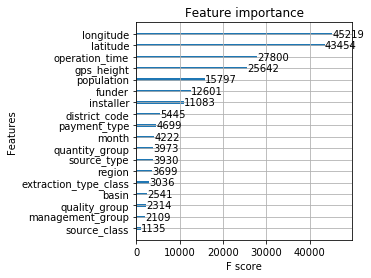

In [ ]:
#F scores from XGB
fig=plt.figure()
plot_importance(Best_Classifiers[-1], ax=plt.gca())
fig.subplots_adjust(left=0.4)

In [ ]:
#Assessment of accuracy on the validation set using early stopping:
best_XGB.fit(X_train, y_train, 
            eval_set=[(X_val, y_val)],
            verbose=100, 
            early_stopping_rounds=50)
                  
best_XGB.score(X_val, y_val)
 

[0]	validation_0-merror:0.230752
Will train until validation_0-merror hasn't improved in 50 rounds.
Stopping. Best iteration:
[49]	validation_0-merror:0.187654



0.8123456790123457

In [ ]:
#Relevant classification metrics
from sklearn.metrics import classification_report

y_pred=best_XGB.predict(X_val).flatten()

print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.91      0.85      4839
           1       0.65      0.27      0.38       647
           2       0.85      0.78      0.81      3424

    accuracy                           0.81      8910
   macro avg       0.77      0.65      0.68      8910
weighted avg       0.81      0.81      0.80      8910



### Training the models on the full data set

The models are now tuned and their performance assessed. We fit (using the full data set now) and save the best performing ones on disk.

In [ ]:
MODELS_PATH = './models'

X_all, X_test, y_all, _, y_encoder=prepare_data(X_all, X_test, y_all, '')


# Preparing data ...

-- Drop unimportant features
-- Convert all invalid values to NaNs
-- Imputing ['longitude','latitude','funder','installer'] in training data
-- Imputing ['longitude','latitude','funder','installer'] in validation data
-- Add new geographical feature, Kmeans-10
-- Impute ['gps_height','population','construction_year'] using Kmeans-10
-- Add month of record as new feature
-- Add operation time and drop date_recorded, date_construction, and K10
-- Bin funders and installers
-- Encode categorical features

# Done.


In [ ]:
from sklearn.externals import joblib

best_LGB.fit(X_all.values,y_all)
joblib.dump(best_LGB, f'{MODELS_PATH}/lgb_full.mdl', compress=True)

best_RF.fit(X_all.values,y_all)
joblib.dump(best_RF, f'{MODELS_PATH}/rf_full.mdl', compress=True)

best_XGB.fit(X_all.values,y_all)
joblib.dump(best_XGB, f'{MODELS_PATH}/xgb_full.mdl', compress=True)


Using cross-validation and early stopping, I train k(=5) variants of each model and save them on disk.

In [ ]:
def train_models(model,X_df,y_np,file_name,k=10,earlystop=50):
    '''Trains 'model' on X,y using 'k'-Stratified-cross-validation.
    Saves the model as 'file_name' on disk at each iteration.
    Returns mean score (accuracy).'''
    
    df_index = np.array(X_df.index)                     
    cv_result=0
        
    folds = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    folds.get_n_splits(X_df, y_np)
    
    print('\nModel Fitting...')
    for counter, cv_indices in enumerate(folds.split(df_index, y_np)):
        print('\nFold {}'.format(counter+1))
        X_fit, y_fit = X_df.values[cv_indices[0]], y_np[cv_indices[0]]
        X_cval, y_cval = X_df.values[cv_indices[1]], y_np[cv_indices[1]]
        
        model.fit(X_fit, y_fit, eval_set=[(X_cval, y_cval)], verbose=earlystop, early_stopping_rounds=earlystop )
        
        joblib.dump(model, f'{MODELS_PATH}/{file_name}{str(counter+1)}.mdl', compress=True)
        
        cv_result += model.score(X_cval, y_cval) 
        
        del X_fit, X_cval, y_fit, y_cval
        gc.collect()
    
    mean_score  = cv_result/k
    
    return mean_score



    

In [ ]:
train_models(XGB_best,X_all,y_train_full,name='xgb_fold-',k=5,earlystop=50)

In [ ]:
train_models(LGB_best,X_all,y_train_full,name='lgb_fold-',k=5,earlystop=100)

In [ ]:
train_models(RF_best,X_all,y_train_full,name='rf_fold-',k=5,earlystop=100)

### Predictions from the different ensembles

The different possibilities to stack the models together can be considered as a new hyperparameter to tune (using cross-validation). I tried different possibilities tuning: number and types of models to uniformly (i.e., unweighted sum) stack, different ways to combine predictions, and different trainings.

Performance (i.e. accuracy in this case) is measured with cross-validation.
For the main variants, I have the following performances:

- 5 CV (LGB+XGB+RF) with soft voting: 0.7857
- 5 CV (LGB+XGB+RF) with hard voting: 0.8147
- 5 CV (XGB+RF) with hard voting: 0.8150
- (XGB + RF + LGB) on full data set: 0.8168
- (XGB + RF) on full data set: 0.8156
- Everything: 0.8153

In [ ]:
from glob import glob
from scipy.stats import mode

def predict_target(saved_model,X_test,voting='soft'):
    '''Loads the CV models saved with train_models (e.g., saved_mdl='xgb_*.mdl') and
    returns their predictions on X_test. 
    Predictions are combined using two possible strategies:
    voting  ='soft' : rounded(mean of votes)
            ='hard' : mode(votes)'''

    models = glob(MODELS_PATH+'/'+saved_mdl)
    
    predictions=[]
    
    print('\nMaking Predictions...\n')
    for counter,mdl_name in enumerate(models):
        print(f'[{counter+1}] Predicting with model {mdl_name}...')

        model = joblib.load(mdl_name)
        predictions += [model.predict(X_test.values)]

    if (voting=='soft'):
        predictions=np.array(predictions)  
        predictions=np.round(predictions.mean(axis=0)).astype(int)
    if (voting=='hard'):
        predictions=np.squeeze(mode(predictions)[0])
        
    indices=X_test['id'].values
    
    return (indices,predictions)


def transform_and_save_target(ind_and_preds, encoder,submission_name="submission.csv")
    '''Transforms the target predictions to their final form using the inverse mapping of the original encoder.
    Saves predictions as submission.csv'''

    indices,predictions=ind_and_preds
    
    transformed_predictions=encoder.inverse_transform(predictions)

    datasubmission=pd.DataFrame(data=[indices, transformed_predictions]).T
    datasubmission.columns=['id','status_group']
    datasubmission.to_csv(submission_name, index=False)

        

    print('\nDone.')


In [ ]:
final_predictions=predict_target('*full*.mdl',X_test_prepared,voting='hard')


transform_and_save_target(final_predictions, y_encoder,submission_name="submission.csv")



Making Predictions...

[1] Predicting with model ./models/xgb_full.mdl...
[2] Predicting with model ./models/lgb_full.mdl...
[3] Predicting with model ./models/rf_full.mdl...


/Users/sofiane/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Done.
